# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="Banana")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [12]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [5]:
import torch
from torch import nn, optim
from collections import deque
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class QModel(nn.Module):
    def __init__(self, state_size=37, actions_size=4, hidden_size=64):
        super(QModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, actions_size),
        )
    
    def update_weights(self, source_model, tau):
        for target_param, local_param in zip(self.parameters(), source_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
    def forward(self, x):
        return self.model(x)
        

class Agent:
    def __init__(self, lr=0.002, gamma=0.99, tau=0.002):
        self.qnet = QModel()
        self.qnet_target = QModel()
        self.qnet_target.update_weights(self.qnet, tau=1.0) # tau=1.0 to initialize the target model with same values
        
        self.lr = lr
        self.gamma = gamma
        self.tau = tau
        
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=self.lr)
        
    def learn(self, replay_buffer, update_target=True): 
        states, actions, rewards, next_states, dones = replay_buffer.sample()
        
        with torch.no_grad():
            next_max_sv = self.qnet_target(next_states).detach().max(dim=-1, keepdim=True)[0]
        targets = rewards + self.gamma * next_max_sv * (1 - dones)

        preds = self.qnet(states).gather(-1, actions)
        loss = nn.functional.mse_loss(preds, targets)
                
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if update_target:
            self.qnet_target.update_weights(self.qnet, tau=self.tau)
            
    def pick_action(self, state, epsilon=0.):
        state = torch.tensor([state]).float().to(device)
        
        dice_roll = np.random.uniform(0.0, 1.0)
        if dice_roll > epsilon: # greedy sampling
            with torch.no_grad():
                return self.qnet(state).argmax(dim=-1).item()
        else: # random sampling
            return np.random.randint(0, 4)
        
    
class ReplayBuffer:
    def __init__(self, buffer_size=1e5, batch_size=128):
        self.batch_size = batch_size
        self.buffer = deque(maxlen=int(buffer_size))  
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))       
    
    def sample(self):
        if len(self.buffer) < self.batch_size:
            sampled_idx = list(range(len(self.buffer)))
        else:
            sampled_idx = random.sample(list(range(len(self.buffer))), k=self.batch_size)
            
        sampled = np.array(self.buffer)[sampled_idx]
        states, actions, rewards, next_states, dones = zip(*sampled)
        
        states = torch.tensor(states).float().to(device)
        actions = torch.tensor(actions).unsqueeze(-1).long().to(device)
        rewards = torch.tensor(rewards).unsqueeze(-1).float().to(device)
        next_states = torch.tensor(next_states).float().to(device)
        dones = torch.tensor(dones).unsqueeze(-1).float().to(device)
        
        return states, actions, rewards, next_states, dones

In [7]:
agent = Agent()

In [8]:
episodes = 500
update_every = 4

scores = []
replay_buffer = ReplayBuffer()

step = 1
eps = 1.0
eps_decay = 0.99
target_avg_score = 13
solved = False

for e in range(1, episodes+1):
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations[0] 
    score = 0 
    while True:
        # choose an action
        action = agent.pick_action(state, epsilon=eps)
        
        # environment responds to the action
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        
        # save state to replay buffer
        replay_buffer.add(state, action, reward, next_state, done)
        
        if step == 0:
            agent.learn(replay_buffer)
        
        score += reward
        step = (step+1) % update_every
        state = next_state
        if done:
            break
    
    eps = eps*eps_decay
        
    scores.append(score)
    last100_avg_score = np.mean(scores[-100:])
    
    if not solved and last100_avg_score > target_avg_score:
        solved = True
        print(f"Environement solved in {e-100} episodes - Last 100 avg score: {last100_avg_score} (eps {eps:.4f})")
    
    if e % 100 == 0:
        print(f"{e} - Last 100 avg score: {last100_avg_score} (eps {eps:.4f})")

100 - Last 100 avg score: 2.06 (eps 0.3660)
200 - Last 100 avg score: 8.28 (eps 0.1340)
300 - Last 100 avg score: 11.5 (eps 0.0490)
Environement solved in 297 episodes - Last 100 avg score: 13.02 (eps 0.0185)
400 - Last 100 avg score: 13.04 (eps 0.0180)
500 - Last 100 avg score: 12.97 (eps 0.0066)


In [9]:
torch.save((agent.qnet.state_dict(), agent.qnet_target.state_dict()), "qnet_models.pt")

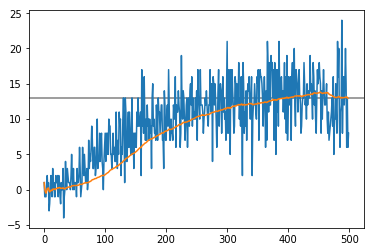

In [11]:
import matplotlib.pyplot as plt

averaged_scores = [np.mean(scores[:i][-100:]) for i in range(1, len(scores))]

plt.axhline(y=13, color='gray')
plt.plot(scores)
plt.plot(averaged_scores)
plt.show()

## Now load the trained model and perform a Test run

In [12]:
qnet_state_dict, qnet_target_state_dict = torch.load("qnet_models.pt")

agent.qnet.load_state_dict(qnet_state_dict)
agent.qnet_target.load_state_dict(qnet_target_state_dict)

agent.qnet.eval(), agent.qnet_target.eval()

(QModel(
   (model): Sequential(
     (0): Linear(in_features=37, out_features=64, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ELU(alpha=1.0)
     (4): Linear(in_features=64, out_features=4, bias=True)
   )
 ), QModel(
   (model): Sequential(
     (0): Linear(in_features=37, out_features=64, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ELU(alpha=1.0)
     (4): Linear(in_features=64, out_features=4, bias=True)
   )
 ))

In [14]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    with torch.no_grad():
        action = agent.pick_action(state)          # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 17.0


In [15]:
env.close()